In [1]:
from sklearn.neural_network import BernoulliRBM
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
from keras.optimizers import Adam
from keras.layers import GRU
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import os
from sklearn.model_selection import train_test_split
import numpy as np
# Параметры
max_words = 10000  # Максимальное количество слов в словаре
maxlen = 500       # Максимальная длина последовательности

def load_data_from_directory(base_dir):
    texts = []  # Тексты отзывов
    labels = []  # Метки (0 - отрицательный, 1 - положительный)

    for label_type in ['neg', 'pos']:
        dir_name = os.path.join(base_dir, label_type)
        for fname in os.listdir(dir_name):
            if fname.endswith('.txt'):
                with open(os.path.join(dir_name, fname), encoding='utf-8') as f:
                    texts.append(f.read())
                # Присваиваем метки: 0 для neg, 1 для pos
                labels.append(0 if label_type == 'neg' else 1)
    
    return texts, labels

# Загрузка данных
train_dir = 'aclimdb/train'
test_dir = 'aclimdb/test'

x_train_texts, y_train = load_data_from_directory(train_dir)
x_test_texts, y_test = load_data_from_directory(test_dir)

# Разделение части данных на валидацию
x_train_texts, x_val_texts, y_train, y_val = train_test_split(
    x_train_texts, y_train, test_size=0.2, random_state=42
)

# Токенизация текста
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train_texts)

# Преобразование текста в последовательности
x_train_seq = pad_sequences(tokenizer.texts_to_sequences(x_train_texts), maxlen=maxlen)
x_val_seq = pad_sequences(tokenizer.texts_to_sequences(x_val_texts), maxlen=maxlen)
x_test_seq = pad_sequences(tokenizer.texts_to_sequences(x_test_texts), maxlen=maxlen)


In [2]:
from keras.layers import Dense, Embedding, SimpleRNN, Dropout
import joblib

import tensorflow as tf

# Отключение всех GPU
tf.config.set_visible_devices([], 'GPU')


y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Токенизация текста
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train_texts)

# Преобразование текста в последовательности
x_train_seq = pad_sequences(tokenizer.texts_to_sequences(x_train_texts), maxlen=maxlen)
x_val_seq = pad_sequences(tokenizer.texts_to_sequences(x_val_texts), maxlen=maxlen)
x_test_seq = pad_sequences(tokenizer.texts_to_sequences(x_test_texts), maxlen=maxlen)

model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=maxlen),  # Векторизация слов с помощью embedding
    SimpleRNN(128, return_sequences=False),  # Используем SimpleRNN вместо GRU
    Dropout(0.5),  # Dropout для предотвращения переобучения
    Dense(64, activation='relu'),  # Полносвязный слой с ReLU активацией
    Dense(1, activation='sigmoid')  # Выходной слой с активацией sigmoid для бинарной классификации
])

# Компиляция модели
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(x_train_seq, y_train, epochs=50, batch_size=32, validation_data=(x_val_seq, y_val))

model.save('RNN.h5')



Epoch 1/50
625/625 [==============================] - 42s 66ms/step - loss: 0.6959 - accuracy: 0.5405 - val_loss: 0.5636 - val_accuracy: 0.7010
Epoch 2/50
625/625 [==============================] - 37s 59ms/step - loss: 0.4995 - accuracy: 0.7679 - val_loss: 0.4429 - val_accuracy: 0.8128
Epoch 3/50
625/625 [==============================] - 37s 59ms/step - loss: 0.4861 - accuracy: 0.7761 - val_loss: 0.5469 - val_accuracy: 0.7756
Epoch 4/50
625/625 [==============================] - 37s 59ms/step - loss: 0.5503 - accuracy: 0.7157 - val_loss: 0.5395 - val_accuracy: 0.7224
Epoch 5/50
625/625 [==============================] - 37s 59ms/step - loss: 0.5783 - accuracy: 0.7017 - val_loss: 0.6189 - val_accuracy: 0.6504
Epoch 6/50
625/625 [==============================] - 36s 57ms/step - loss: 0.5085 - accuracy: 0.7563 - val_loss: 0.4733 - val_accuracy: 0.7896
Epoch 7/50
625/625 [==============================] - 36s 57ms/step - loss: 0.4277 - accuracy: 0.8097 - val_loss: 0.4511 - val_accuracy:

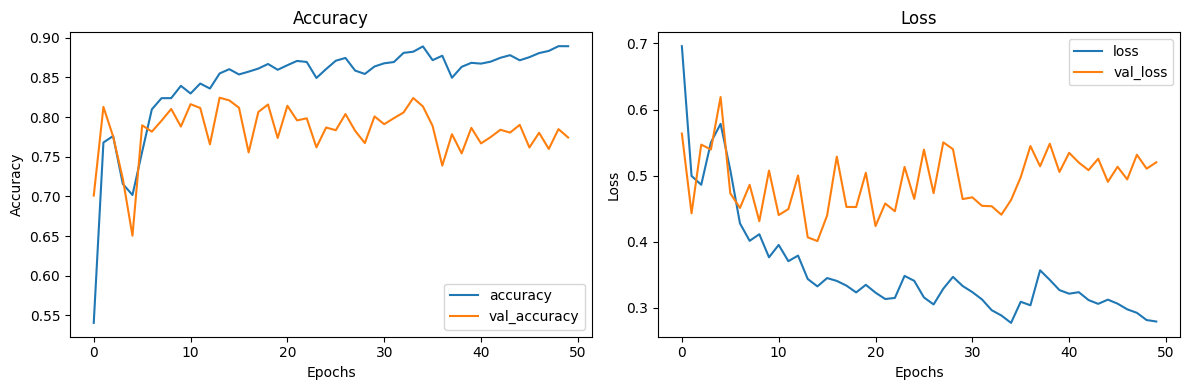

In [ ]:
import matplotlib.pyplot as plt

# Построение графиков точности и ошибки
plt.figure(figsize=(12, 4))

# График точности
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# График ошибки потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [2]:

import joblib
# Преобразование последовательностей в двумерный массив для обучения RBM (с каждым словом как признаком)
# Сначала переводим данные в формат (число образцов, число слов в словаре) с использованием one-hot encoding
x_train_onehot = np.zeros((x_train_seq.shape[0], max_words))
for i, seq in enumerate(x_train_seq):
    for word_idx in seq:
        if word_idx < max_words:
            x_train_onehot[i, word_idx] = 1

x_val_onehot = np.zeros((x_val_seq.shape[0], max_words))
for i, seq in enumerate(x_val_seq):
    for word_idx in seq:
        if word_idx < max_words:
            x_val_onehot[i, word_idx] = 1

# Обучение ограниченной машины Больцмана (RBM)
rbm = BernoulliRBM(n_components=128, learning_rate=0.1, n_iter=10, random_state=42)
x_train_rbm = rbm.fit_transform(x_train_onehot)
x_val_rbm = rbm.transform(x_val_onehot)

joblib.dump(rbm, 'BernoulliRBM')

['BernoulliRBM']

In [11]:
import numpy as np
import joblib
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Преобразование последовательностей в двумерный массив для обучения RBM (с каждым словом как признаком)
# Сначала переводим данные в формат (число образцов, число слов в словаре) с использованием one-hot encoding
x_train_onehot = np.zeros((x_train_seq.shape[0], max_words))
for i, seq in enumerate(x_train_seq):
    for word_idx in seq:
        if word_idx < max_words:
            x_train_onehot[i, word_idx] = 1

x_val_onehot = np.zeros((x_val_seq.shape[0], max_words))
for i, seq in enumerate(x_val_seq):
    for word_idx in seq:
        if word_idx < max_words:
            x_val_onehot[i, word_idx] = 1

# Определение x_test_onehot (one-hot encoding для тестовых данных)
x_test_onehot = np.zeros((x_test_seq.shape[0], max_words))
for i, seq in enumerate(x_test_seq):
    for word_idx in seq:
        if word_idx < max_words:
            x_test_onehot[i, word_idx] = 1

# Загрузка предобученной модели RBM
rbm = joblib.load('BernoulliRBM')

# Преобразование обучающих и валидационных данных с использованием RBM
x_train_rbm = rbm.transform(x_train_onehot)
x_val_rbm = rbm.transform(x_val_onehot)

# Строим полносвязную модель с использованием Keras
model = Sequential([
    Dense(128, input_dim=x_train_rbm.shape[1], activation='relu'),  # Входной слой с количеством нейронов, равным размерности выхода из RBM
    Dense(64, activation='relu'),  # Второй скрытый слой
    Dense(1, activation='sigmoid')  # Выходной слой для бинарной классификации
])

# Компиляция модели
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Обучение модели
history = model.fit(x_train_rbm, y_train, epochs=50, batch_size=32, validation_data=(x_val_rbm, y_val))

# Оценка на тестовых данных
x_test_rbm = rbm.transform(x_test_onehot)
test_loss, test_accuracy = model.evaluate(x_test_rbm, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

model.save('FC.h5')


Epoch 1/50
625/625 [==============================] - 3s 5ms/step - loss: 0.3645 - accuracy: 0.8400 - val_loss: 0.3787 - val_accuracy: 0.8324
Epoch 2/50
625/625 [==============================] - 3s 4ms/step - loss: 0.3376 - accuracy: 0.8527 - val_loss: 0.3331 - val_accuracy: 0.8516
Epoch 3/50
625/625 [==============================] - 3s 4ms/step - loss: 0.3354 - accuracy: 0.8558 - val_loss: 0.3298 - val_accuracy: 0.8504
Epoch 4/50
625/625 [==============================] - 2s 4ms/step - loss: 0.3298 - accuracy: 0.8586 - val_loss: 0.3334 - val_accuracy: 0.8516
Epoch 5/50
625/625 [==============================] - 3s 4ms/step - loss: 0.3289 - accuracy: 0.8557 - val_loss: 0.3303 - val_accuracy: 0.8518
Epoch 6/50
625/625 [==============================] - 2s 4ms/step - loss: 0.3242 - accuracy: 0.8595 - val_loss: 0.3278 - val_accuracy: 0.8530
Epoch 7/50
625/625 [==============================] - 2s 3ms/step - loss: 0.3240 - accuracy: 0.8618 - val_loss: 0.3303 - val_accuracy: 0.8514
Epoch 

782/782 [==============================] - 0s 453us/step
Model based on RBM:
Accuracy:  0.82212
F1 Score (macro):  0.8218411825909713
F1 Score by class:  [0.81479322 0.82888915]
              precision    recall  f1-score   support

           0       0.85      0.78      0.81     12500
           1       0.80      0.86      0.83     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000

782/782 [==============================] - 13s 16ms/step
Model based on RNN:
Accuracy:  0.78352
F1 Score (macro):  0.7835154985078698
F1 Score by class:  [0.78450267 0.78252833]
              precision    recall  f1-score   support

           0       0.78      0.79      0.78     12500
           1       0.79      0.78      0.78     12500

    accuracy                           0.78     25000
   macro avg       0.78      0.78      0.78     25000
weighted avg       0.78      0.78      0.78  

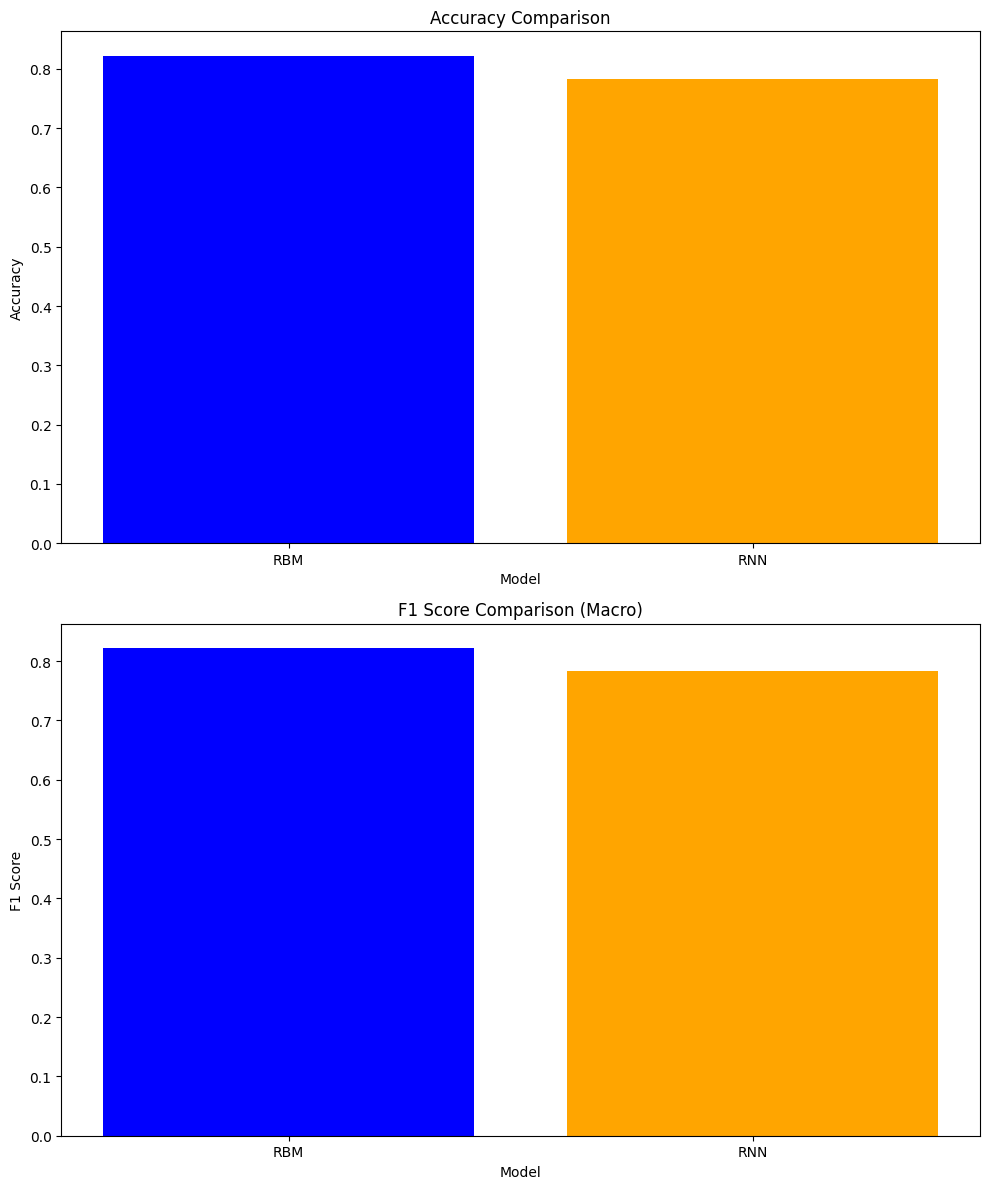

In [11]:
import numpy as np
import joblib
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
from keras.models import load_model

# Определение x_test_onehot (one-hot encoding для тестовых данных)
x_test_onehot = np.zeros((x_test_seq.shape[0], max_words))
for i, seq in enumerate(x_test_seq):
    for word_idx in seq:
        if word_idx < max_words:
            x_test_onehot[i, word_idx] = 1

# --- RBM Evaluation ---
# Загрузка модели RBM
model_rbm = load_model('FC.h5')  # Модель для RBM
rbm = joblib.load("BernoulliRBM")

# Трансформация тестовых данных с использованием RBM
x_test_rbm = rbm.transform(x_test_onehot)

# Предсказание на тестовом наборе
y_pred_rbm = model_rbm.predict(x_test_rbm)
y_pred_rbm = (y_pred_rbm > 0.5).astype(int)

# Метрики для модели RBM
accuracy_rbm = accuracy_score(y_test, y_pred_rbm)
f1_rbm = f1_score(y_test, y_pred_rbm, average='macro')
f1_rbm_class = f1_score(y_test, y_pred_rbm, average=None)

print("Model based on RBM:")
print("Accuracy: ", accuracy_rbm)
print("F1 Score (macro): ", f1_rbm)
print("F1 Score by class: ", f1_rbm_class)
print(classification_report(y_test, y_pred_rbm))

# --- RNN Evaluation ---
# Загрузка модели RNN
model_rnn = load_model("RNN.h5")

# Предсказание на тестовом наборе
y_pred_rnn = model_rnn.predict(x_test_seq)
y_pred_rnn = (y_pred_rnn > 0.5).astype(int)

# Метрики для модели RNN
accuracy_rnn = accuracy_score(y_test, y_pred_rnn)
f1_rnn = f1_score(y_test, y_pred_rnn, average='macro')
f1_rnn_class = f1_score(y_test, y_pred_rnn, average=None)

print("Model based on RNN:")
print("Accuracy: ", accuracy_rnn)
print("F1 Score (macro): ", f1_rnn)
print("F1 Score by class: ", f1_rnn_class)
print(classification_report(y_test, y_pred_rnn))

# --- Plotting Comparison ---
# Графики сравнения метрик
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Accuracy plot
ax[0].bar(['RBM', 'RNN'], [accuracy_rbm, accuracy_rnn], color=['blue', 'orange'])
ax[0].set_title('Accuracy Comparison')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('Accuracy')

# F1 Score plot
ax[1].bar(['RBM', 'RNN'], [f1_rbm, f1_rnn], color=['blue', 'orange'])
ax[1].set_title('F1 Score Comparison (Macro)')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('F1 Score')

plt.tight_layout()
plt.show()


In [23]:
def predict_sentiment(text, tokenizer, maxlen, model_rnn, rbm, model_rbm):
    """
    Функция для предсказания класса (положительный или отрицательный) для одного текста.

    Параметры:
    - text: строка с текстом для предсказания
    - tokenizer: токенайзер, использованный при обучении
    - maxlen: максимальная длина последовательности
    - model_rnn: загруженная модель RNN
    - rbm: обученная ограниченная машина Больцмана (RBM)
    - model_rbm: загруженная полносвязная модель для RBM
    
    Возвращает:
    - Предсказание от обеих моделей: (RNN, RBM)
    """
    # Преобразование текста в последовательность
    seq = tokenizer.texts_to_sequences([text])
    padded_seq = pad_sequences(seq, maxlen=maxlen)
    
    # --- Предсказание от модели RNN ---
    rnn_pred = model_rnn.predict(padded_seq)
    rnn_class = "Positive" if rnn_pred[0] > 0.5 else "Negative"

    # --- Предсказание от модели RBM ---
    # Преобразование последовательности в one-hot encoding
    onehot_seq = np.zeros((1, max_words))
    for word_idx in seq[0]:
        if word_idx < max_words:
            onehot_seq[0, word_idx] = 1

    rbm_transformed = rbm.transform(onehot_seq)
    rbm_pred = model_rbm.predict(rbm_transformed)
    rbm_class = "Positive" if rbm_pred[0] > 0.5 else "Negative"

    return {"RNN Prediction": rnn_class, "RBM Prediction": rbm_class}

# Пример использования функции
input_text = "i would eat my leg neither watch this"
result = predict_sentiment(
    text=input_text,
    tokenizer=tokenizer,
    maxlen=maxlen,
    model_rnn=model_rnn,
    rbm=rbm,
    model_rbm=model_rbm
)

print(f"Input text: {input_text}")
print(f"RNN Prediction: {result['RNN Prediction']}")
print(f"RBM Prediction: {result['RBM Prediction']}")


1/1 [==============================] - 0s 15ms/step
Input text: i would eat my leg neither watch this
RNN Prediction: Negative
RBM Prediction: Negative
